In [1]:
using Pkg
Pkg.activate("/Users/ryansenne/Documents/GitHub/SSM")

include("/Users/ryansenne/Documents/Github/SSM//src/SSM.jl")
using .SSM
using LinearAlgebra
using Random
using Distributions
using Plots

  Activating project at `\Users\ryansenne\Documents\GitHub\SSM`

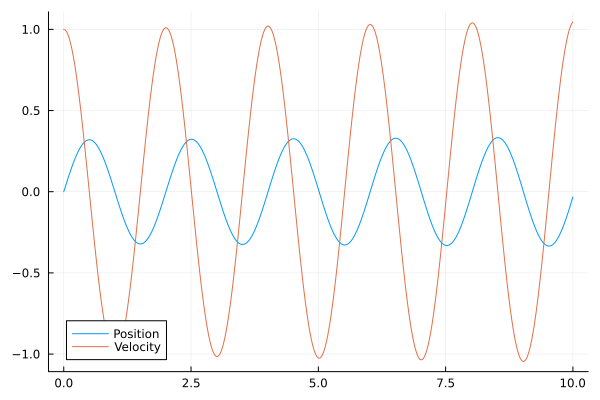

In [2]:
# Generate data from a known linear dynamical system--a pendulum
g = 9.81 # gravity
l = 1.0 # length of pendulum
dt = 0.001 # time step
T = 10.0 # total time
# Discrete-time dynamics
A = [1.0 dt; -g/l*dt 1.0]
# Initial state
x0 = [0.0; 1.0]
# Time vector
t = 0:dt:T
# Generate data
x = zeros(2, length(t))
x[:,1] = x0
for i = 2:length(t)
    x[:,i] = A*x[:,i-1]
end
# Plot data 
plot(t, x[1,:], label="Position")
plot!(t, x[2,:], label="Velocity")

In [3]:
# Now lets add noise to the system and see if we can recover the dynamics
# Add driving Gaussian noise to simulate observations
x_noisy = zeros(2, length(t))
x_noisy[:, 1] = x0
observation_noise_std = 0.5

noise = rand(Normal(0, observation_noise_std), (2, length(t)))

for i in 2:length(t)
    x_noisy[:, i] = A * x[:, i-1] + noise[:, i]
end

# Define the LDS model parameters
H = I(2)  # Observation matrix (assuming direct observation)
Q = 1e-8* I(2)  # Process noise covariance
R = (observation_noise_std^2) * I(2)  # Observation noise covariance
P0 = 1e-4 * I(2)  # Initial state covariance
x0 = [0.0; 1.0]  # Initial state mean

# Create the Kalman filter parameter vector
kf = LDS(A, Matrix{Float64}(H), nothing, Matrix{Float64}(Q), Matrix{Float64}(R), x0, Matrix{Float64}(P0), nothing, 2, 2, "Gaussian", Vector([true, true, false, true, true, true, true, false]))

# x̂ = SSM.matrix_Kalman_Smoother(kf, x_noisy[:, 1:100]')
# Run the Kalman filter
x_pred, P, v, F, K, ll = KalmanFilter(kf, Matrix{Float64}(x_noisy'))

# Run the smoother
x_smooth, P_smooth, time_cov = KalmanSmoother(kf, Matrix{Float64}(x_noisy'))

([0.05696162447333572 1.0055496743359194; 0.05795011093682116 1.0049896345124534; … ; -0.030644328764074497 1.0532971921633782; -0.029591037409811404 1.0535979198916552], [0.0001 0.0; 9.997010481727942e-5 -8.802955180479192e-7; … ; 1.644302099722019e-5 -4.50022610326207e-6; 1.6443015713497643e-5 -4.500537166344005e-6;;; 0.0 0.0001; -8.802955180479192e-7 9.997962081182953e-5; … ; -4.500226103262078e-6 0.00015781185907940836; -4.500537166344013e-6 0.00015781197340163897], [0.00010000000000000145 -9.810000000019226e-7; 9.996922452176283e-5 -1.8610022463073543e-6; … ; 1.6438520771116928e-5 -4.6615321392447984e-6; 1.6437355658105623e-5 -4.658293628219116e-6;;; 1.0000000000036697e-7 0.00010000000000000814; -7.803158972357075e-7 9.998825651086975e-5; … ; -4.34241424418267e-6 0.00015785600629748134; -4.339286887359483e-6 0.00015775628185362502])

In [4]:
ll

-14556.47849081126

In [5]:
SSM.loglikelihood(kf, Matrix{Float64}(x_noisy'))

-8.143832007072532e7

In [6]:
SSM.loglikelihood_X(x_smooth, kf, x_noisy')

17678.489575660034

In [45]:
x_test = rand(2, 100)

grad = SSM.∇ₗₗ(x_test', kf, x_noisy[:, 1:100]')
hessian = SSM.∇²ₗₗ(x_test', kf, x_noisy[:, 1:100]')

200×200 Matrix{Float64}:
  1.9002e6  -2.0e6      0.0       …   0.0         0.0         0.0
 -2.0e6      4.0002e6  -2.0e6         0.0         0.0         0.0
  0.0       -2.0e6      4.0002e6      0.0         0.0         0.0
  0.0        0.0       -2.0e6         0.0         0.0         0.0
  0.0        0.0        0.0           0.0         0.0         0.0
  0.0        0.0        0.0       …   0.0         0.0         0.0
  0.0        0.0        0.0           0.0         0.0         0.0
  0.0        0.0        0.0           0.0         0.0         0.0
  0.0        0.0        0.0           0.0         0.0         0.0
  0.0        0.0        0.0           0.0         0.0         0.0
  ⋮                               ⋱                          
  0.0        0.0        0.0           0.0         0.0         0.0
  0.0        0.0        0.0           0.0         0.0         0.0
  0.0        0.0        0.0           0.0         0.0         0.0
  0.0        0.0        0.0           0.0         0.0  

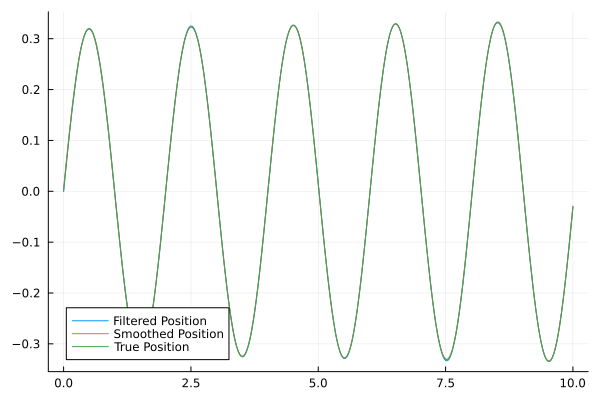

In [33]:
# plot the results
# plot(t, x_noisy[1, :], label="Noisy Position")
plot(t, x_pred[:, 1], label="Filtered Position")
plot!(t, x_smooth[:, 1], label="Smoothed Position")
plot!(t, x[1, :], label="True Position")


In [13]:
# now create a Kalman Filter where we want to learn the parameters
kf_unknown = LDS(; obs_dim=2, latent_dim=2, emissions="Gaussian", fit_bool=[true, true, false, true, true, true, true])


LDS([0.7559476244119153 0.3094964910018072; 0.5680803486087219 0.262671430034939], [0.3259434575527206 0.4388873915717887; 0.07034467383906207 0.0377157427899204], nothing, Bool[1 0; 0 1], Bool[1 0; 0 1], [0.487858008597868, 0.1859926639493561], [0.7886493615898449 0.7939083050346492; 0.3097896771994896 0.10595336568667235], nothing, 2, 2, "Gaussian", Bool[1, 1, 0, 1, 1, 1, 1])

In [8]:
SSM.KalmanFilterEM!(kf_unknown, Matrix{Float64}(x_noisy'), 1)

PosDefException: PosDefException: matrix is not positive definite; Cholesky factorization failed.

In [14]:
KalmanFilterOptim!(kf_unknown, x_noisy')


PosDefException: PosDefException: matrix is not positive definite; Cholesky factorization failed.

In [10]:
SSM.loglikelihood(kf_unknown, Matrix{Float64}(x_noisy'))

PosDefException: PosDefException: matrix is not positive definite; Cholesky factorization failed.

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\ryansenne\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\ryansenne\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\ryansenne\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191


┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\ryansenne\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\ryansenne\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191


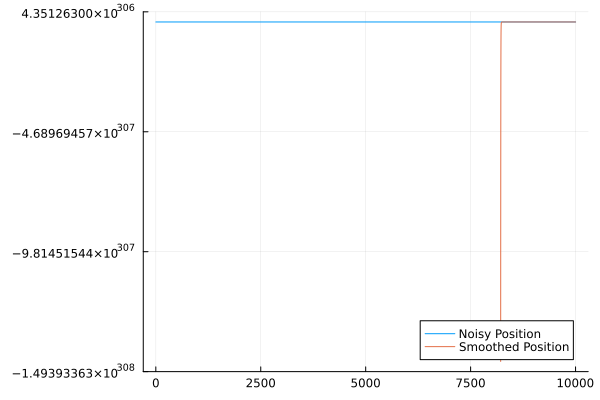

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\ryansenne\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\ryansenne\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191


In [50]:
x_smooth_unknown, P_smooth_unknown = KalmanSmoother(kf_unknown, Matrix{Float64}(x_noisy'))

plot(x_noisy[1, :], label="Noisy Position")
plot!(x_smooth_unknown[:, 1], label="Smoothed Position")